借助 Intel(R) Extension for Scikit-learn，您可以加速您的 Scikit-learn 应用程序，并且仍然完全符合所有 Scikit-Learn API 和算法。这是一款免费软件 AI 加速器，可为各种应用带来超过10-100 倍的加速。而且您甚至不需要更改现有代码！

In [39]:
# pip install scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [40]:
from keras.layers import Input, Dense, LSTM ,Conv1D,Dropout,Bidirectional,Multiply
from keras.models import Model
# from attention_utils import get_activations
import  pandas as pd
import  numpy as np

from tensorflow.keras.layers import Lambda, Permute, RepeatVector, Reshape, Dense
import keras.backend as K 
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler


In [41]:


def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print('shape为',layer_activations.shape)
            print(layer_activations)
    return activations


def get_data(n, input_dim, attention_column=1):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y


def get_data_recurrent(n, time_steps, input_dim, attention_column=10):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network    should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y[:], (1, input_dim))
    return x, y


def get_data_recurrent2(n, time_steps, input_dim, attention_dim=5):
    """
    Suppose input_dim = 10  time_steps = 6
    formed one  x 6 x 10 The data of each step 6 dimension is the same as y
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:,:,attention_dim] =  np.tile(y[:], (1, time_steps))


    return x,y
     

In [42]:

 

SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    #a = Permute((2, 1))(inputs)
    #a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

# Another way of writing the attention mechanism is suitable for the use of the above error source:https://blog.csdn.net/uhauha2929/article/details/80733255
def attention_3d_block2(inputs, single_attention_vector=False):
    # If the upper layer is LSTM, you need return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # Multiplied by the attention weight, but there is no summation, it seems to have little effect
    # If you classify tasks, you can do Flatten expansion
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul



def create_dataset(dataset:pd.DataFrame, look_back:int):
    '''
    Processing the data
    '''
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset.iloc[i:(i+look_back),1:]
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back,:])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)

    return TrainX, Train_Y



def attention_model():
    # inputs = Input(((data.shape[1],1)))
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = Conv1D(filters = 64,kernel_size =32,dilation_rate=2,padding="same", activation="relu")(inputs)
    # x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    x = Dropout(drop)(x)

    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #For GPU you can use CuDNNLSTM
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True,name='bilstm'))(x)
    lstm_out = Dropout(drop)(lstm_out)

    #attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(lstm_out)

    #output = Dense(1, activation='sigmoid')(attention_mul)
    output = Dense(1, activation='linear')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model
     

In [ ]:
from tensorflow import keras, tf

keras.layers.Activation('linear')

In [43]:


dfstate = pd.read_csv("./data/states.txt")
dfstate["start"] = dfstate.apply(
    lambda row: row["date"] + " " + row["start_time"], axis=1
)
dfstate["end"] = dfstate.apply(lambda row: row["date"] + " " + row["end_time"], axis=1)
dfstate["label"] = dfstate.pop("state").str.strip()
# 转为时间类型
dfstate[["start", "end"]] = dfstate[["start", "end"]].apply(pd.to_datetime)
# dfstate["statev"] = dfstate.apply(label_to_number, axis=1)
# dfstate['label'] = dfstate.apply(number_to_label,axis=1)
dfstate.to_csv("./data/states.csv")
print(dfstate.head(), dfstate.shape)
 

         date start_time  end_time               start                 end  \
0  2023-12-17   10:44:49  10:48:59 2023-12-17 10:44:49 2023-12-17 10:48:59   
1  2023-12-17   11:29:45  11:31:55 2023-12-17 11:29:45 2023-12-17 11:31:55   
2  2023-12-17   12:23:56  12:29:44 2023-12-17 12:23:56 2023-12-17 12:29:44   
3  2023-12-17   12:55:08  12:56:28 2023-12-17 12:55:08 2023-12-17 12:56:28   
4  2023-12-17   13:45:02  13:45:42 2023-12-17 13:45:02 2023-12-17 13:45:42   

  label  
0     装  
1     卸  
2     装  
3     卸  
4     装   (56, 6)


In [44]:
# 定义读取，处理数据函数
def fix_data(inputDF: pd.DataFrame) -> pd.DataFrame:
    # 创建一个新的空列用于存储结果

    inputDF.insert(0, "label", "-")

    # 对df1中的每一行遍历，并查找df2中符合条件的记录
    for index, row in inputDF.iterrows():
        condition = (dfstate["start"] <= row["时间"]) & (row["时间"] <= dfstate["end"])
        match = dfstate[condition]

        if not match.empty:
            # 如果找到了匹配项，则将df2的'state'赋值给df1的新列
            inputDF.at[index, "label"] = match["label"].values[0]
        else:
            # 如果没有找到匹配项，则保持原样（这里已经初始化为-）
            pass

    # inputDF.insert(1,'state',0)
    # inputDF["state"] = inputDF["label"].astype("category").cat.codes
    return inputDF


def read_data(file_path: str) -> pd.DataFrame:
    return fix_data(
        pd.read_excel(file_path, engine="openpyxl", parse_dates=["时间", "轨迹时间"])
    )


# 读取数据
df17 = read_data("./data/data_17.xlsx")
df21 = read_data("./data/data_21.xlsx")
df22 = read_data("./data/data_22.xlsx")
df23 = read_data("./data/data_23.xlsx")


In [45]:

data = pd.concat([df17, df21], axis=0, ignore_index=True).drop([ "轨迹时间"], axis = 1)
number_types = [np.number]
label_types = ["object"]
time_types = ["datetime64[ns]"]
numeric_cols = data.select_dtypes(include=number_types).columns.tolist()
label_cols = data.select_dtypes(include=label_types).columns.tolist()
time_cols = data.select_dtypes(include=time_types).columns.tolist()
print(numeric_cols,label_cols,time_cols)
print(data.columns)
print(data.shape)

df22= df22.drop([ "轨迹时间"], axis = 1)
df23= df23.drop([ "轨迹时间"], axis = 1)


['原始重量', '稳定重量', '轴重', 'su_ad', 'wpu_x', 'wpu_y', 'wpu_z', 'su_x', 'su_y', 'su_z', '原始重量_diff', '稳定重量_diff', '轴重_diff', 'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff', 'su_x_diff', 'su_y_diff', 'su_z_diff', '速度', '估计重量', '原始重量加速度', '稳定重量加速度', '原始重量加速度_二阶', '稳定重量加速度_二阶'] ['label'] ['时间']
Index(['label', '时间', '原始重量', '稳定重量', '轴重', 'su_ad', 'wpu_x', 'wpu_y', 'wpu_z',
       'su_x', 'su_y', 'su_z', '原始重量_diff', '稳定重量_diff', '轴重_diff',
       'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff', 'su_x_diff',
       'su_y_diff', 'su_z_diff', '速度', '估计重量', '原始重量加速度', '稳定重量加速度',
       '原始重量加速度_二阶', '稳定重量加速度_二阶'],
      dtype='object')
(41494, 28)


findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Sourc

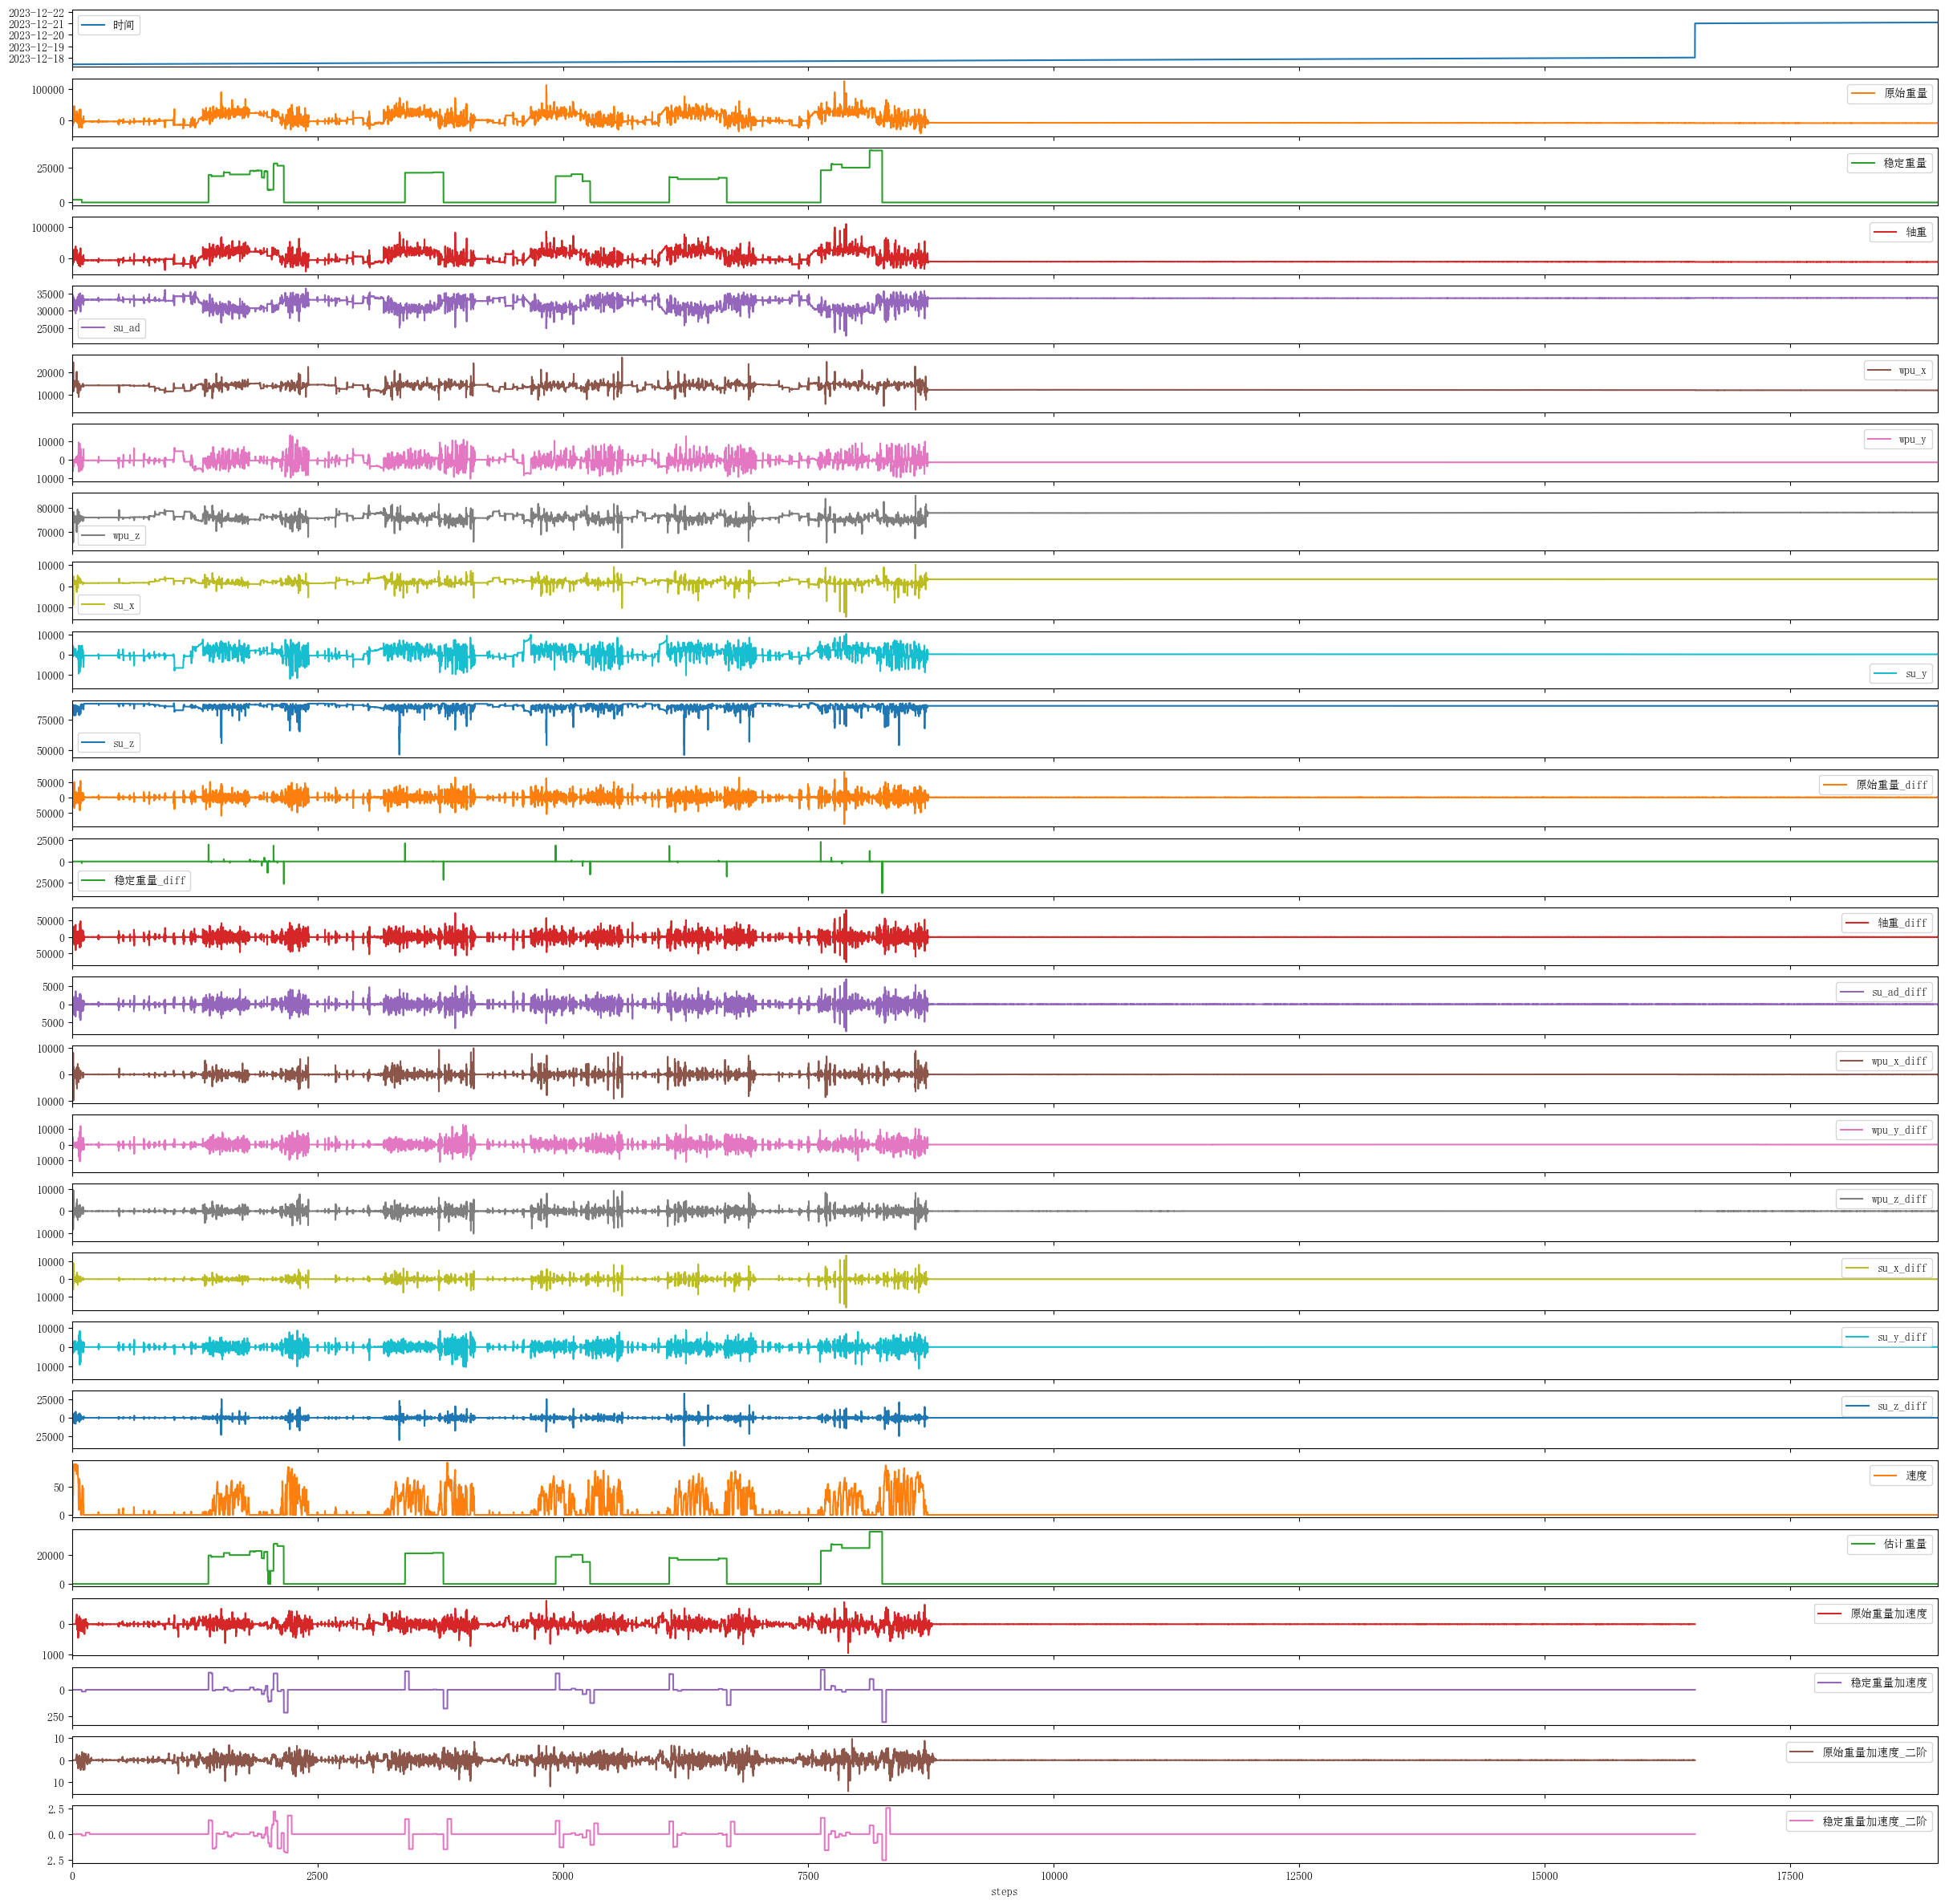

In [46]:


data.plot(legend=True, subplots=True, figsize=(30,30),  xlabel="steps")
ax = plt.gca()
ax.set_xlim(left=0, right=19000)

# 或者直接指定字体文件路径
plt.rcParams['font.sans-serif'] = ['SimHei']  # 系统自带的黑体
plt.rcParams['font.serif'] = ['SimSun']  # 系统自带的宋体
plt.rcParams['font.family'] = ['SimSun','SimHei','Source Han Sans CN'] 

# plt.show()


### 改各自层数！

In [47]:
from typing import Tuple

def normalize(inpudf: pd.DataFrame,numeric_cols:list,label_cols:list,time_cols:list) -> Tuple[pd.DataFrame , StandardScaler,LabelEncoder]:

    # 使用 StandardScaler 或者 MinMaxScaler 进行标准化处理。
    # 创建标准化器对象
    scaler = StandardScaler()
    scaler.fit(inpudf[numeric_cols])

    # （label）标准化
    le = LabelEncoder()
    #["装", "卸",'-']
    le.fit(inpudf[label_cols])

    # newdata=np.array(inpudf)
    # 数值型数据标准化： 使用StandardScaler或者MinMaxScaler进行标准化处理。
    for col in numeric_cols:
        inpudf[col] = le.fit_transform(inpudf[col])

    # 类别数据（label）标准化： 类别数据通常不做标准化，而是进行编码，比如One-Hot编码或者Label Encoding。
    for col in label_cols:
        inpudf[col] = le.fit_transform(inpudf[col])
    # 时间数据标准化： 时间数据通常不进行标准化，而是转换成可以比较的形式，如Unix时间戳或时间段差。
    # 将所有时间列转换为Unix时间戳（单位为秒）
    for col in time_cols:
        inpudf[col] = (
            inpudf[col].astype(np.int64) / 1e9
        )  # 默认pandas的datetime64[ns]转换为Unix时间戳（秒）

    return inpudf,scaler,le


# 反标准化


def denormalize(inpudf: pd.DataFrame,scaler:StandardScaler,le:LabelEncoder) -> pd.DataFrame:
    """对df中的数值列进行反标准化处理"""

    # 数值型数据标准化-
    inpudf[numeric_cols] = scaler.inverse_transform(inpudf[numeric_cols])

    # 类别数据（label）标准化-
    for col in label_cols:
        inpudf[col] = le.inverse_transform(inpudf[col])

    # 时间数据标准化-
    for col in time_cols:
        inpudf[col] = pd.to_datetime(
            inpudf[col] * 1e9
        )  # 默认pandas的datetime64[ns]转换为Unix时间戳（秒）

    return inpudf 

In [48]:
INPUT_DIMS = len(numeric_cols)+ len(time_cols)
TIME_STEPS = 50
lstm_units = 64
drop = 0
numeric_cols = [ '原始重量', '稳定重量', '轴重', 'su_ad', 
                'wpu_x', 'wpu_y', 'wpu_z',
                'su_x', 'su_y', 'su_z', 
                '原始重量_diff', '稳定重量_diff', '轴重_diff',
                'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff',
                'su_x_diff','su_y_diff', 'su_z_diff', 
                '速度', '估计重量']

# ['原始重量', '稳定重量', '轴重', 'su_ad', 
#                 'wpu_x', 'wpu_y', 'wpu_z', 
#                 'su_x', 'su_y', 'su_z', 
#                 '原始重量_diff', '稳定重量_diff', '轴重_diff', 
#                 'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff',
#                 'su_x_diff', 'su_y_diff', 'su_z_diff', 
#                 '速度', '估计重量', '原始重量加速度', '稳定重量加速度', '原始重量加速度_二阶', '稳定重量加速度_二阶'] 
label_cols = ['label']
time_cols = ['时间']
#Normalized
data,scaler,le = normalize(data,numeric_cols,label_cols,time_cols)


from sklearn.model_selection import train_test_split
import keras 
X = data[numeric_cols]
Y = data['label']
# display(X)
# print(Y)
x_train, x_test, y_train, y_test = train_test_split(np.asarray(X), np.asarray(Y), test_size=0.33, shuffle= True)

# The known number of output classes.
num_classes = 3
colums_num = 22 # len(numeric_cols)
print(len(numeric_cols))
# Input image dimensions
input_shape = (colums_num,1)

# Convert class vectors to binary class matrices. This uses 1 hot encoding.
y_train_binary = keras.utils.to_categorical(y_train,num_classes)
y_test_binary = keras.utils.to_categorical(y_test,num_classes)
 
x_train = x_train.reshape(len(x_train), colums_num,1)
x_test = x_test.reshape(len(x_test), colums_num,1)


22


c:\Users\tangj15\AppData\Local\anaconda3\envs\py310_tf26\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
from __future__ import print_function    
from keras.models import Sequential
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

model = Sequential()
model.add(Conv1D(32, (3), input_shape=(colums_num,1), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
# model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 20, 32)            128       
                                                                 
 flatten_1 (Flatten)         (None, 640)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                41024     
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 41347 (161.51 KB)
Trainable params: 41347 (161.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:


batch_size = 128
epochs = 100
history = model.fit(x_train, y_train_binary,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test_binary))

Epoch 1/100
218/218 [==============================] - 1s 3ms/step - loss: 1331.9917 - accuracy: 0.0090 - val_loss: 1076.9518 - val_accuracy: 0.0092
Epoch 2/100
218/218 [==============================] - 1s 2ms/step - loss: 760.6320 - accuracy: 0.0113 - val_loss: 378.0266 - val_accuracy: 0.0139
Epoch 3/100
218/218 [==============================] - 1s 3ms/step - loss: 182.3723 - accuracy: 0.5490 - val_loss: 93.0137 - val_accuracy: 0.6902
Epoch 4/100
218/218 [==============================] - 1s 3ms/step - loss: 42.1982 - accuracy: 0.7811 - val_loss: 16.7595 - val_accuracy: 0.9044
Epoch 5/100
218/218 [==============================] - 1s 3ms/step - loss: 13.6970 - accuracy: 0.9304 - val_loss: 12.4835 - val_accuracy: 0.9439
Epoch 6/100
218/218 [==============================] - 1s 3ms/step - loss: 11.4144 - accuracy: 0.9533 - val_loss: 11.5300 - val_accuracy: 0.9538
Epoch 7/100
218/218 [==============================] - 1s 3ms/step - loss: 10.6496 - accuracy: 0.9592 - val_loss: 10.9014 -

findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Sourc

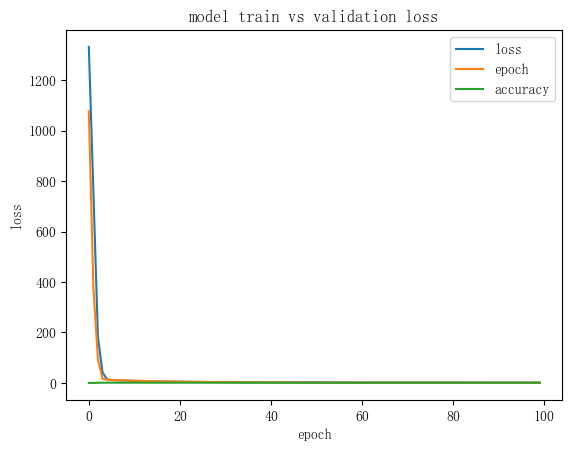

findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Sourc

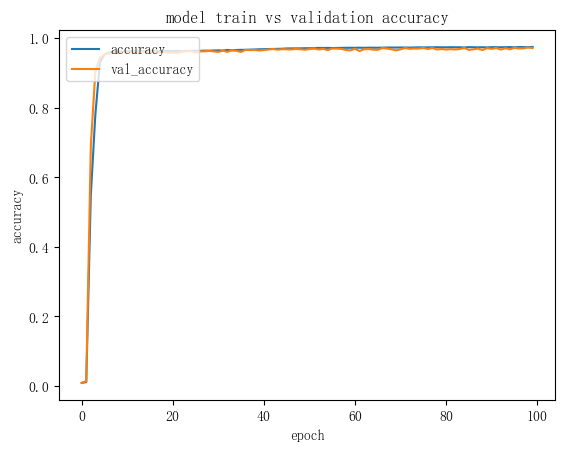

In [51]:
#display(history.history)
plt.plot( history.history['loss'])
plt.plot( history.history['val_loss'])
plt.plot( history.history['val_accuracy'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'epoch','accuracy'], loc='upper right')
plt.show()
plt.plot( history.history['accuracy'])
plt.plot( history.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()
 

In [52]:
display(df22.columns)

Index(['label', '时间', '原始重量', '稳定重量', '轴重', 'su_ad', 'wpu_x', 'wpu_y', 'wpu_z',
       'su_x', 'su_y', 'su_z', '原始重量_diff', '稳定重量_diff', '轴重_diff',
       'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff', 'su_x_diff',
       'su_y_diff', 'su_z_diff', '速度', '估计重量'],
      dtype='object')

In [53]:

df22,scaler22,le22 = normalize(df22,numeric_cols,label_cols,time_cols)
df23,scaler23,le23 = normalize(df23,numeric_cols,label_cols,time_cols)

x_df22 = df22[numeric_cols]
y_df22 = df22['label']
y_df22 = keras.utils.to_categorical(np.asfarray(y_df22),num_classes) 
x_df22=np.asfarray(x_df22)
x_df22 = x_df22.reshape(len(x_df22), colums_num,1)
results22 = model.predict(x_df22)
display(results22)

c:\Users\tangj15\AppData\Local\anaconda3\envs\py310_tf26\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


c:\Users\tangj15\AppData\Local\anaconda3\envs\py310_tf26\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


873/873 [==============================] - 1s 1ms/step


array([[1.0000000e+00, 8.7779336e-23, 1.5834445e-30],
       [1.0000000e+00, 5.6258442e-23, 5.7746343e-31],
       [1.0000000e+00, 3.4792480e-20, 1.6245248e-28],
       ...,
       [9.9999845e-01, 1.5461077e-06, 0.0000000e+00],
       [1.0000000e+00, 2.3133115e-08, 0.0000000e+00],
       [9.9999976e-01, 2.2227988e-07, 0.0000000e+00]], dtype=float32)

findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Source Han Sans CN' not found.
findfont: Font family 'Sourc

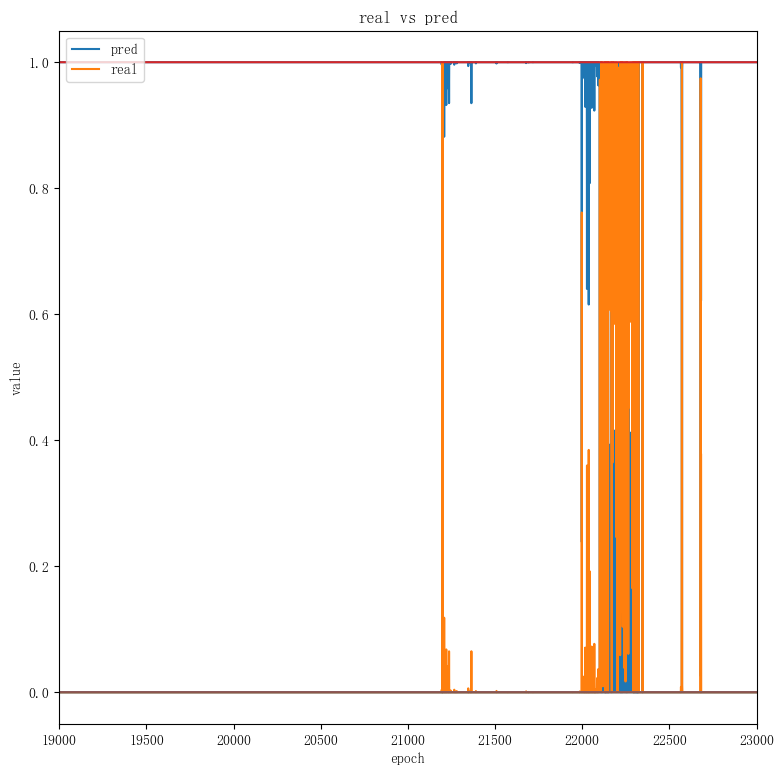

In [54]:

fig_acc = plt.figure(figsize=(9, 9))
plt.plot(results22[0:27000])
plt.plot(y_df22[0:27000])
plt.title('real vs pred')
plt.ylabel('value')
plt.xlabel('epoch')
plt.xlim((19000, 23000))
plt.legend(['pred', 'real'], loc='upper left')
plt.show()

In [55]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

print('以下是CNN_biLSTM_Attention误差')
print('R^2决定系数：',r2_score(test_Y[000:14000],results[00:14000]))
print('RMSE为：',np.sqrt(mean_squared_error(test_Y[2500:18000],results[2500:18000])))
print('MAPE为：',(abs(results[9000:15000] -test_Y[9000:15000])/ test_Y[9000:15000]).mean())

以下是CNN_biLSTM_Attention误差


NameError: name 'test_Y' is not defined

In [ ]:
test_new=[]
predict_new=[] 

for k in range(len(results)):
    if test_Y[k]!=0:
        test_new.append(test_Y[k])
        predict_new.append(results[k])

def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.fabs((y_true - y_pred) / y_true))
mape = format(MAPE(test_new, predict_new), '.4f') 
mape